# Wstęp do Multimediów - Laboratorum 4
## Kamil Jaworski, nr indeksu 335201

Numer_indeksu % liczba_zdjęć = x

In [11]:
nr_zdj = 335201 % 36
print("numer zdjęcia po losowaniu: ", nr_zdj)

numer zdjęcia po losowaniu:  5


In [2]:
%pip install numpy matplotlib opencv-python


Note: you may need to restart the kernel to use updated packages.


In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

image, wymiary: (512, 768), typ danych: uint8, wartości: 2 - 255


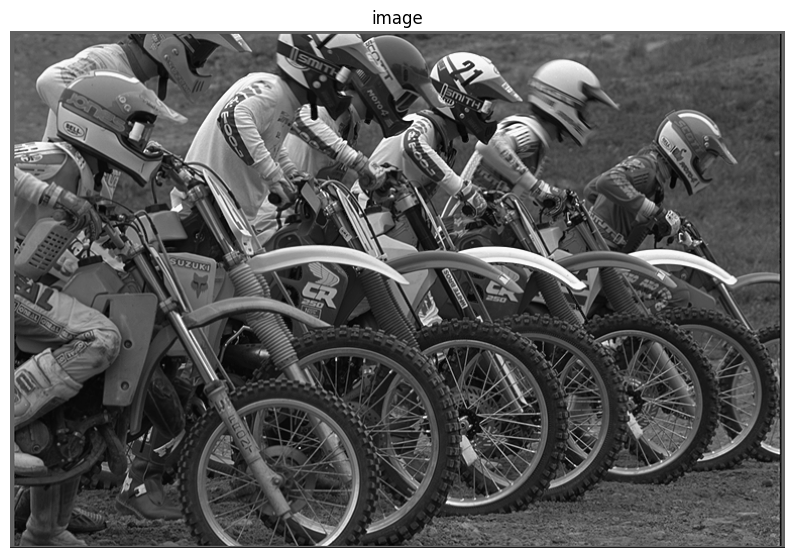

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

path = r"..\LAB_5\monochrome\bikes_mono.png"  # Użyj raw string lub zastąp ścieżkę na odpowiednią dla Twojego systemu

def printi(img, img_title="image"):
    """ Pomocnicza funkcja do wypisania informacji o obrazie. """
    print(f"{img_title}, wymiary: {img.shape}, typ danych: {img.dtype}, wartości: {img.min()} - {img.max()}")

def plt_imshow(img, img_title="image"):
    """
    Funkcja do wyświetlania obrazu z wykorzystaniem Matplotlib w Jupyter Notebook.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.title(img_title)
    plt.axis('off')
    plt.show()

# Ładowanie obrazu
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # Upewnij się, że ścieżka jest poprawna
if img is not None:
    printi(img)
    plt_imshow(img)
else:
    print("Nie udało się wczytać obrazu. Sprawdź ścieżkę do pliku.")


Entropia obrazu monochromatycznego

In [2]:
def calc_entropy(hist):
    pdf = hist/hist.sum() ### normalizacja histogramu -> rozkład prawdopodobieństwa; UWAGA: niebezpieczeństwo '/0' dla 'zerowego' histogramu!!!
    # entropy = -(pdf*np.log2(pdf)).sum() ### zapis na tablicach, ale problem z '/0'
    entropy = -sum([x*np.log2(x) for x in pdf if x != 0])
    return entropy

image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
hist_image = cv2.calcHist([image], [0], None, [256], [0, 256])

hist_image = hist_image.flatten()

H_image = calc_entropy(hist_image)
print(f"H(image) = {H_image:.4f}")

H(image) = 7.3599


obraz różnicowy

image_hdiff, wymiary: (512, 767), typ danych: int16, wartości: -211 - 219
image_hdiff_0, wymiary: (512, 1), typ danych: int16, wartości: -95 - -28
image_hdiff, wymiary: (512, 768), typ danych: int16, wartości: -211 - 219


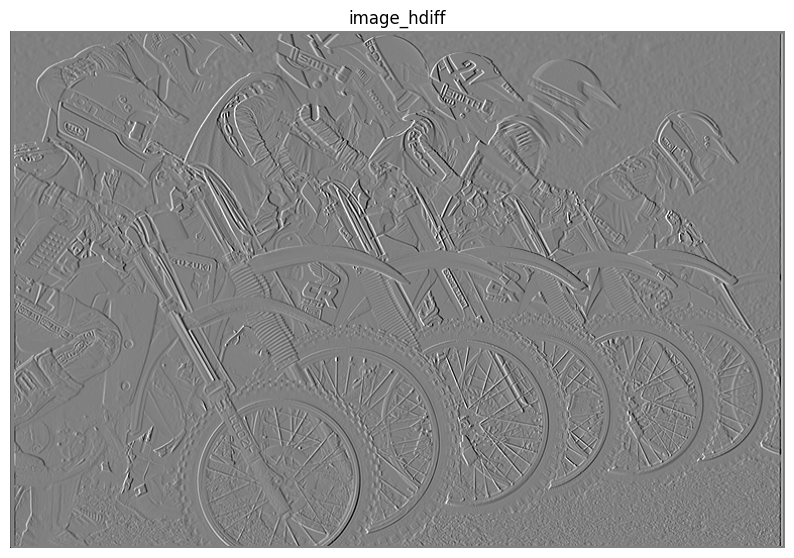

H(image) = 7.3599
H(hdiff) = 5.8910


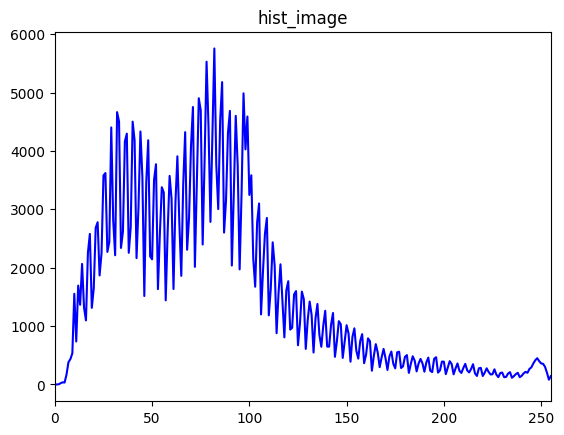

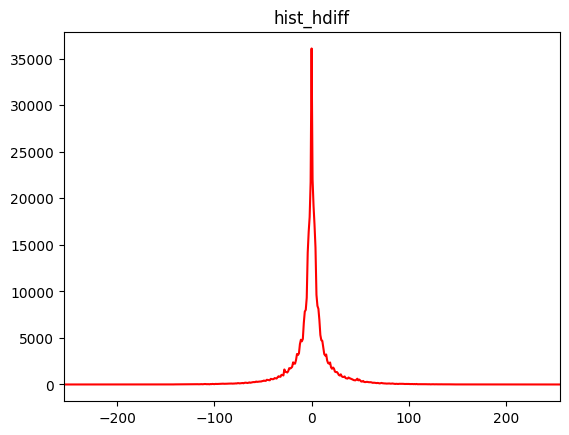

In [4]:

img_tmp1 = image[:, 1:] 
img_tmp2 = image[:, :-1] 


image_hdiff = cv2.addWeighted(img_tmp1, 1, img_tmp2, -1, 0, dtype=cv2.CV_16S)
printi(image_hdiff, "image_hdiff")

image_hdiff_0 = cv2.addWeighted(image[:, 0], 1, 0, 0, -127, dtype=cv2.CV_16S) ### od 'zerowej' kolumny obrazu oryginalnego odejmowana stała wartość '127'
printi(image_hdiff_0, "image_hdiff_0")
image_hdiff = np.hstack((image_hdiff_0, image_hdiff)) ### połączenie tablic w kierunku poziomym, czyli 'kolumna za kolumną'
printi(image_hdiff, "image_hdiff")

# przesunięcie zakresu poprzez dodanie połowy zakresu (0-255) oraz obcięcie wartości wychodzących poza zakres
image_hdiff_scaled = np.clip(image_hdiff + 128, 0, 255).astype(np.uint8)
plt_imshow(image_hdiff_scaled, "image_hdiff")             

cv2.waitKey(0)          
cv2.destroyAllWindows() 

image_tmp = (image_hdiff+255).astype(np.uint16)
hist_hdiff = cv2.calcHist([image_tmp], [0], None, [511], [0, 511]).flatten()
# print(hist_hdiff.sum())

H_image = calc_entropy(hist_image)
print(f"H(image) = {H_image:.4f}")

H_hdiff = calc_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")

# Wyświetlenie histogramów
plt.figure()
plt.plot(hist_image, color="blue")
plt.title("hist_image")
plt.xlim([0, 255])
plt.figure()
plt.plot(np.arange(-255, 256, 1), hist_hdiff, color="red") 
plt.title("hist_hdiff")
plt.xlim([-255, 255])

plt.show() 


DWT

LL, wymiary: (256, 384), typ danych: uint8, wartości: 0 - 255
LH, wymiary: (256, 384), typ danych: int16, wartości: -126 - 139
HL, wymiary: (256, 384), typ danych: int16, wartości: -139 - 151
HH, wymiary: (256, 384), typ danych: int16, wartości: -164 - 212


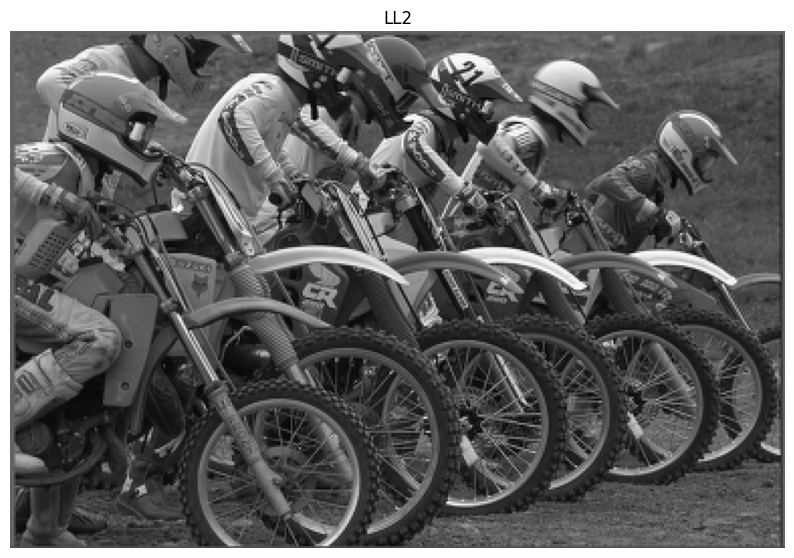

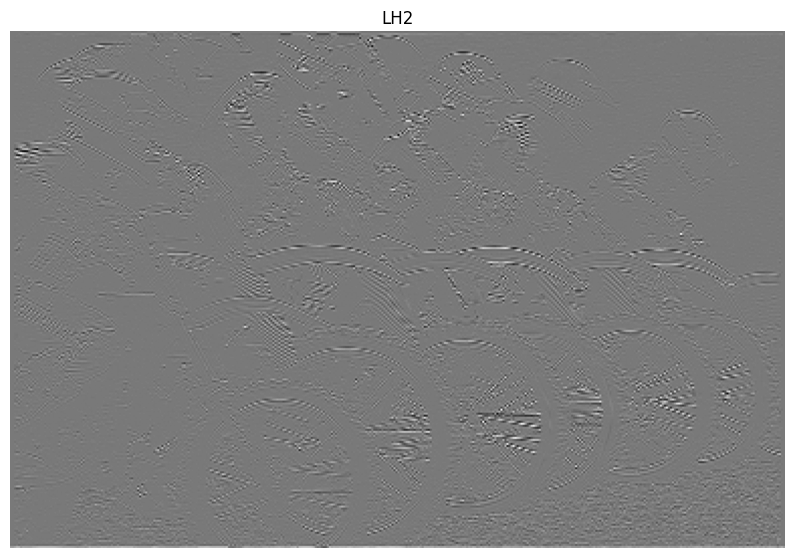

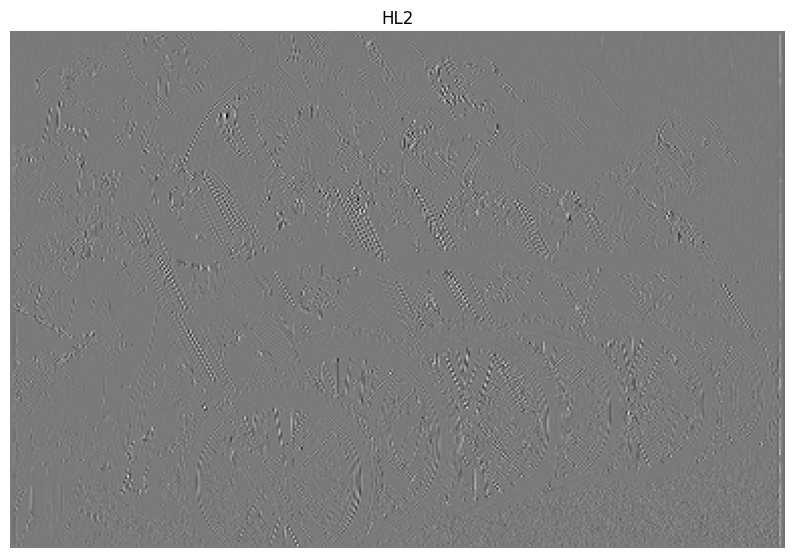

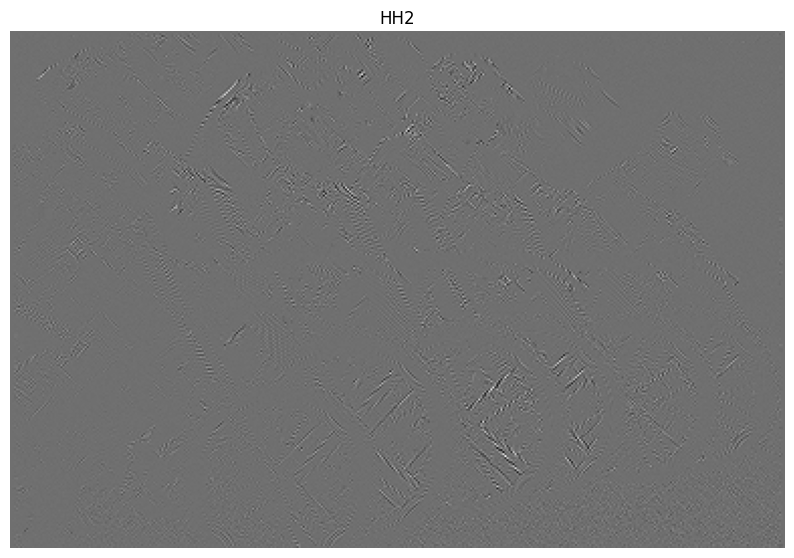

H(LL) = 7.3746 
H(LH) = 5.3553 
H(HL) = 5.2674 
H(HH) = 5.2771 
H_śr = 5.8186


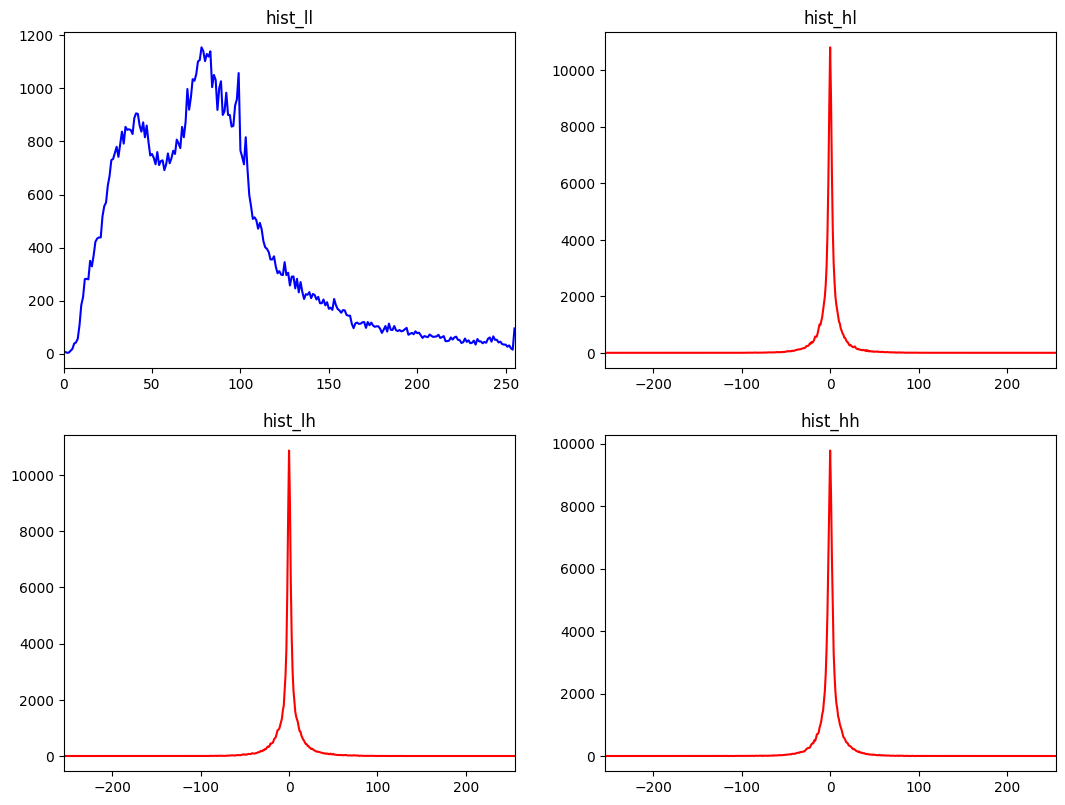

In [6]:
skip_wnd = False

def dwt(img):
    """
    Bardzo prosta i podstawowa implementacja, nie uwzględniająca efektywnych metod obliczania DWT
    i dopuszczająca pewne niedokładności.
    """
    maskL = np.array([0.02674875741080976, -0.01686411844287795, -0.07822326652898785, 0.2668641184428723,
        0.6029490182363579, 0.2668641184428723, -0.07822326652898785, -0.01686411844287795, 0.02674875741080976])
    maskH = np.array([0.09127176311424948, -0.05754352622849957, -0.5912717631142470, 1.115087052456994,
        -0.5912717631142470, -0.05754352622849957, 0.09127176311424948])

    bandLL = cv2.sepFilter2D(img,         -1, maskL, maskL)[::2, ::2]
    bandLH = cv2.sepFilter2D(img, cv2.CV_16S, maskL, maskH)[::2, ::2] ### ze względu na filtrację górnoprzepustową -> wartości ujemne, dlatego wynik 16-bitowy ze znakiem
    bandHL = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskL)[::2, ::2]
    bandHH = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskH)[::2, ::2]

    return bandLL, bandLH, bandHL, bandHH


ll, lh, hl, hh = dwt(image)
printi(ll, "LL")
printi(lh, "LH")
printi(hl, "HL")
printi(hh, "HH")

plt_imshow(ll, "LL2")
plt_imshow(cv2.multiply(lh, 2), "LH2") ### cv2.multiply() -> zwiększenie kontrastu obrazów 'H', żeby lepiej uwidocznić
plt_imshow(cv2.multiply(hl, 2), "HL2")
plt_imshow(cv2.multiply(hh, 2), "HH2")

cv2.waitKey(0)

""" Entropia dla obrazów pasmowych """

hist_ll = cv2.calcHist([ll], [0], None, [256], [0, 256]).flatten()
hist_lh = cv2.calcHist([(lh+255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten() ### zmiana zakresu wartości i typu danych ze względu na cv2.calcHist() (jak wcześniej przy obrazach różnicowych)
hist_hl = cv2.calcHist([(hl+255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
hist_hh = cv2.calcHist([(hh+255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
H_ll = calc_entropy(hist_ll)
H_lh = calc_entropy(hist_lh)
H_hl = calc_entropy(hist_hl)
H_hh = calc_entropy(hist_hh)
print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll+H_lh+H_hl+H_hh)/4:.4f}")

""" Wyświetlenie histogramów - jeden obraz z czterema pod-obrazami """
fig = plt.figure()
fig.set_figheight(fig.get_figheight()*2) ### zwiększenie rozmiarów okna
fig.set_figwidth(fig.get_figwidth()*2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("hist_ll")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("hist_lh")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("hist_hl")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("hist_hh")
plt.xlim([-255, 255])

if not skip_wnd: plt.show() 
cv2.destroyAllWindows() 